# Circuit of HHL Algorithm using Qiskit

This notebook will teach you how to construct your own circuits for the HHL algorithm using Qiskit.

# Install Qiskit

Install Qiskit if you haven't. Here we are not installing the latest version of Qiskit since it has an issue with displaying circuits using matplotlib (fancy circuits) in Colab.

In [ ]:
!pip install qiskit==0.16.1

# Importing Packages

In [ ]:
from qiskit import * # No need to explain why
import matplotlib as mpl # Required to display some fancy circuits
import numpy as np # Required to play around with matrices and pi

In [ ]:
X_gate = np.matrix([[0, 1], [1, 0]]) # Required to create the input matrix

#The problem

Now we move on to the main section. In this notebook, we will explain the construction of basic circuits capable of carrying out the HHL algorithm. The HHL algorithm is a quantum algorithm capable of solving linear systems of equation by being able to invert an input matrix and multiply it with any vector (state). Given a matrix $\mathbf{A} \in \mathbb{R} ^ {N \times N}$ and a vector (normalized) $b \in \mathbb{R} ^ N$, the HHL algorithm is capable of producing the state $|x\rangle \propto \mathbf{A} ^ {-1} b$. Let $u_i$ be the eigenvectors of $\mathbf{A}$ and $b = \sum \limits_i b_i u_i$. Then $|x\rangle \propto \sum \limits_{i} \frac{b_i}{\lambda_i} u_i$, where $\lambda_i$ are eigenvalues of $\mathbf{A}$.

In this notebook, we will be considering a hermitian matrix $\mathbf{A}$, even though we can carry out HHL for non-Hermitian matrices also. The algorithm can be seen as follows:

1. Prepare the state $|b\rangle|0\rangle|0\rangle = \sum \limits_{i = 0} ^ {N-1}b_i |u_i\rangle|0\rangle|0\rangle$, where $|u_i\rangle$ are the eigenvectors of $\mathbf{A}$.
2. Using $e^{iA}$ (Hamiltonian simulation), carry out quantum phase estimation to get the state $\sum \limits_{i = 0} ^ {N-1}b_i |u_i\rangle|\lambda_i\rangle|0\rangle$, where $\lambda_i$ are the eigenvalues.
3. Then, apply the unitary $\mathbf{U}|x\rangle |0\rangle = |x\rangle \Big( \frac{C}{x} |0\rangle +  \sqrt{1-\frac{C^2}{x^2}} |1\rangle \Big)$ on the second and third registers to obtain the state $\sum \limits_{i = 0} ^ {N-1}b_i |u_i\rangle|\lambda_i\rangle \Big( \frac{C}{\lambda_i} |0\rangle + \sqrt{1-\frac{C^2}{\lambda_i^2}} |1\rangle \Big)$, where $C \leq \lambda_i \ \forall \ i$. 
4. Uncompute the phase estimation from step 2 to get the state $\sum \limits_{i = 0} ^ {N-1}b_i |u_i\rangle| 0\rangle \Big( \frac{C}{\lambda_i} |0\rangle + \sqrt{1-\frac{C^2}{\lambda_i^2}} |1\rangle \Big)$.
5. Measure the last qubit. If the outcome is $0$, then we get the state $\sum \limits_{i = 0} ^ {N-1}\frac{b_i}{\lambda_i} |u_i\rangle| 0\rangle |0\rangle $.

The final circuit can then be seen as 

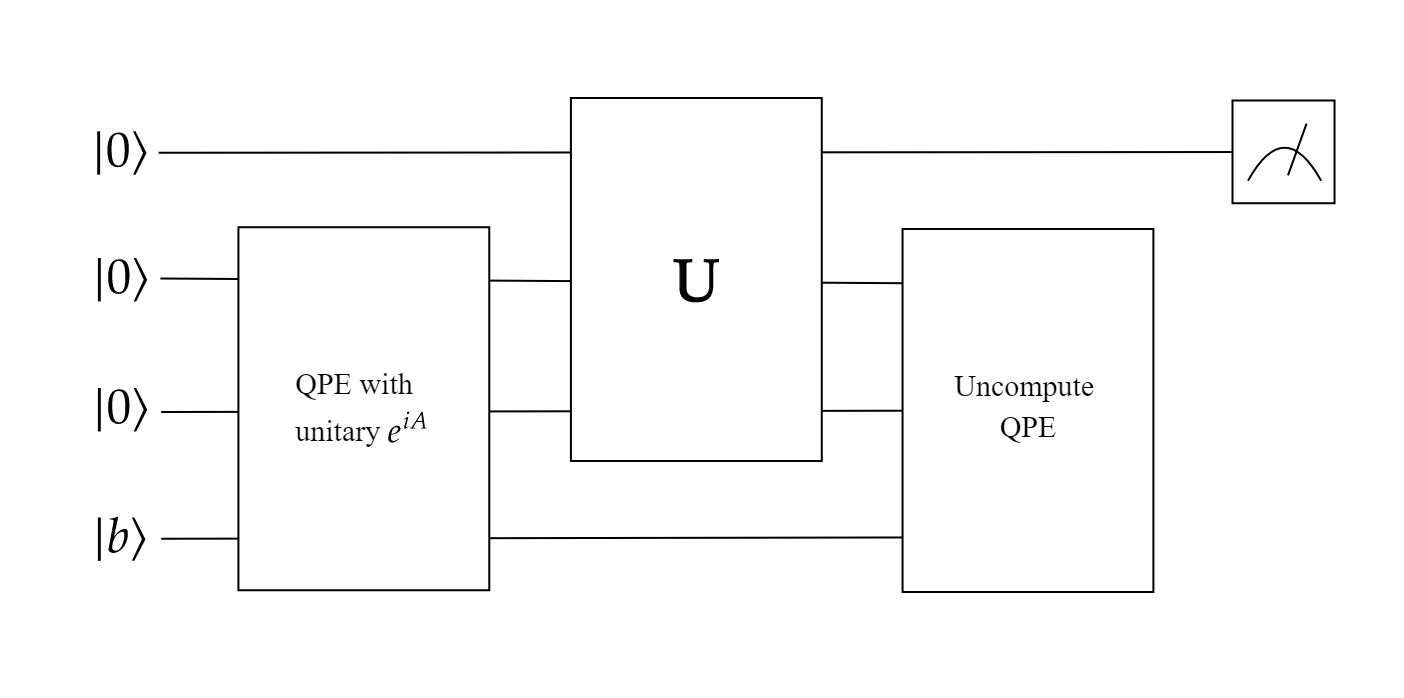

# The circuit

In this example, we shall use $\mathbf{A}$ as the matrix 

\begin{equation}
  \mathbf{A} =
  \begin{bmatrix}
    2.3561945 & 0.78539817 \\
    0.78539817 & 2.3561945
  \end{bmatrix} 
\end{equation}

and the state $|b\rangle$ as the vector $[1 \ \ 2]$ normalized.
This matrix can be written as $\mathbf{A} = 2.3561945 \mathbf{I} + 0.78539817 \mathbf{X}$. Since this is a sum of commuting matrices, this can be easily exponentiated. The phases of the eigenvalues of this matrix are $0.5$ and $0.25$, which means that using $2$ qubits is the second register, we can achieve a perfect phase estimation. Then the phase estimation circuit can be seen as 

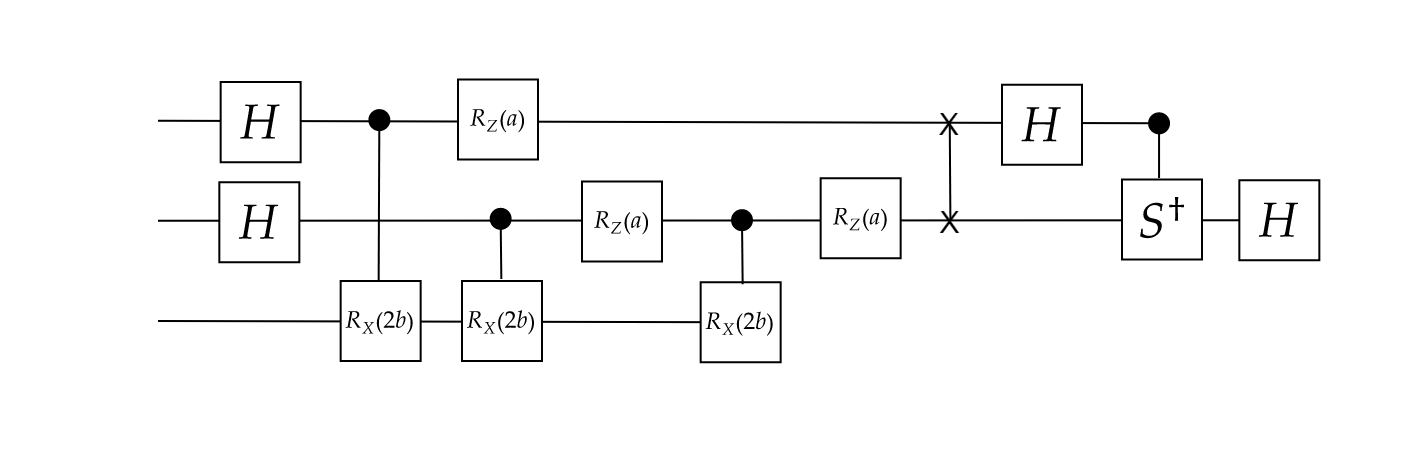

Here, $a = 2.3561945, b = 0.78539817$. The $\mathbf{U}$ gate acting on a two qubit input register can be decomposed as $\mathbf{U} = |0\rangle \langle 0| \otimes \mathbf{I} + \sum \limits_{j = 1} ^ 3 |j\rangle \langle j| \otimes \mathbf{R}_y(2 \cos ^ {-1} (\frac{4C}{2 \pi j}))$. $\mathbf{U}$ can be built using an ancillary qubit as

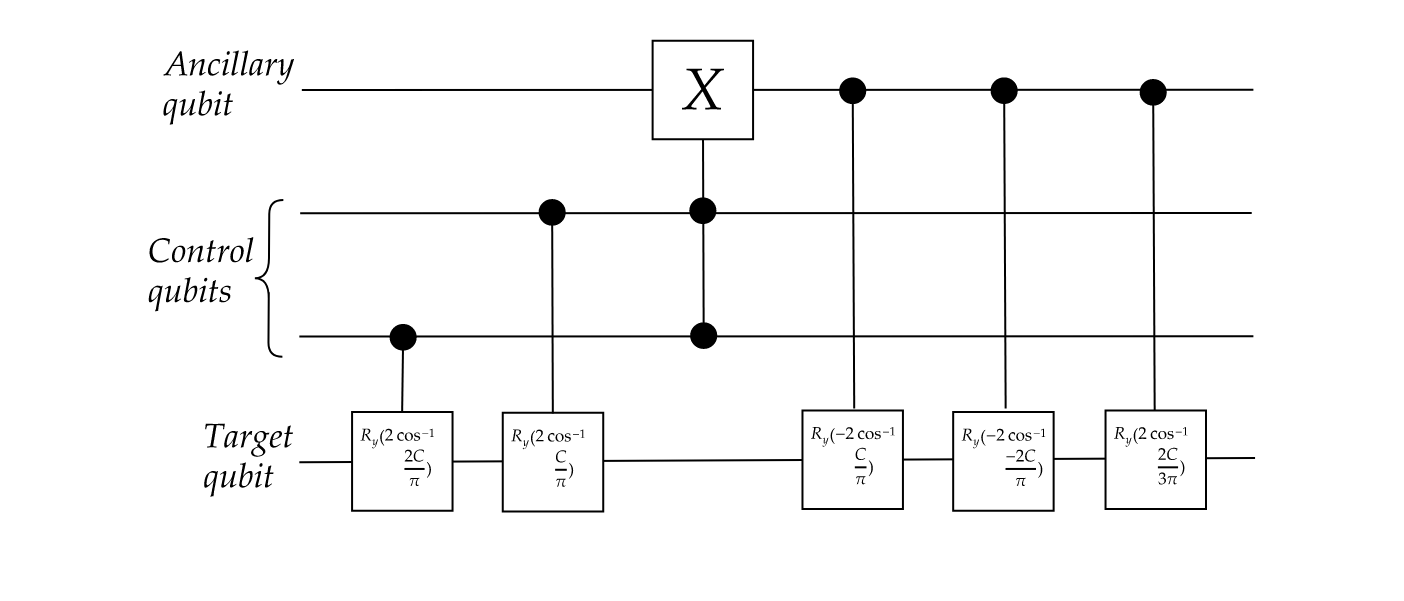

Hence, the final circuit that we wish to implement will have the form

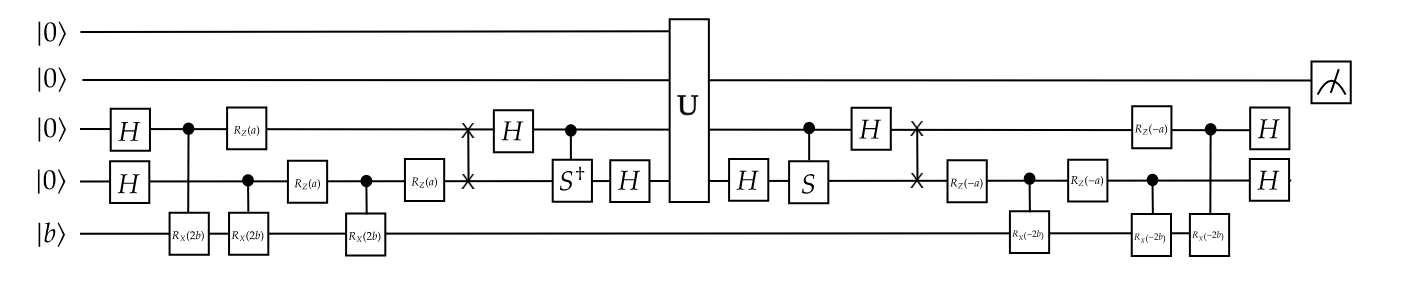

First, we prepare the quantum register. As we can see, from the circuit, the quantum register comprises of 4 qubits. Hence

In [ ]:
# Prepare the quantum register
qr = QuantumRegister(4)

Since we measure $1$ qubit, the classical register requires only $1$ qubit.

In [ ]:
# Prepare the classical register
cr = ClassicalRegister(1)

Using the quantum register, we now define the quantum circuit

In [ ]:
# Prepare quantum circuit
qc = QuantumCircuit(qr, cr)

Now, we shall start applying the gates. We start with initializing qubit $3$ as the state $|b\rangle$.

In [ ]:
y = np.array([1,2])
y = y/np.linalg.norm(y)

qc.initialize(y, [3])

Next step is to carry out phsae estimation with the exponentiated matrix.

In [ ]:
a = 2.3561945
b = 0.78539817

# Apply Hadamrd gates
for i in range(2):
  qc.h(i + 1)

# Apply controlled exponentiated matrix
for control_qubit in range(2):
  for times in range(2 ** control_qubit):
    qc.cu3(2 * b, -np.pi/2, np.pi/2, control_qubit + 1, 3)
    qc.u1(a, control_qubit + 1)

# Apply inverse QFT
qc.swap(1,2)

qc.h(1)

qc.cu1(-np.pi/2, 1, 2)
qc.h(2)


Let's take a look at the circuit built so far.

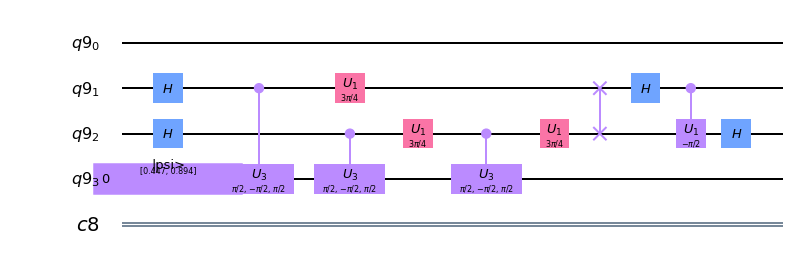

In [ ]:
qc.draw(output = 'mpl')

Now we shall apply the gate U.

In [ ]:
# Apply U
C = 1.5
eig = np.pi/2
qc.cu3(2 * np.arccos(C/eig), 0, 0, 2, 0)

eig = np.pi
qc.cu3(2 * np.arccos(C/eig), 0, 0, 1, 0)

qc.ccx(1, 2, 4)

eig = np.pi
qc.cu3(-2 * np.arccos(C/eig), 0, 0, 4, 0)

eig = np.pi/2
qc.cu3(-2 * np.arccos(C/eig), 0, 0, 4, 0)

eig = 3 * np.pi/2
qc.cu3(2 * np.arccos(C/eig), 0, 0, 4, 0)


Now uncompute the phase estimation process.

In [ ]:
# Apply QFt
qc.h(2)
qc.cu1(np.pi/2, 1, 2)

qc.h(1)

qc.swap(1,2)

# Apply the inverse of the controlled operations
for control_qubit in range(1, -1, -1):
  for times in range(2 ** control_qubit):
    qc.u1(-a, control_qubit + 1)
    qc.cu3(-2 * b, -np.pi/2, np.pi/2, control_qubit + 1, 3)


for i in range(clock_qubits):
  qc.h(i + 1)


Let's take a look at the circuit again

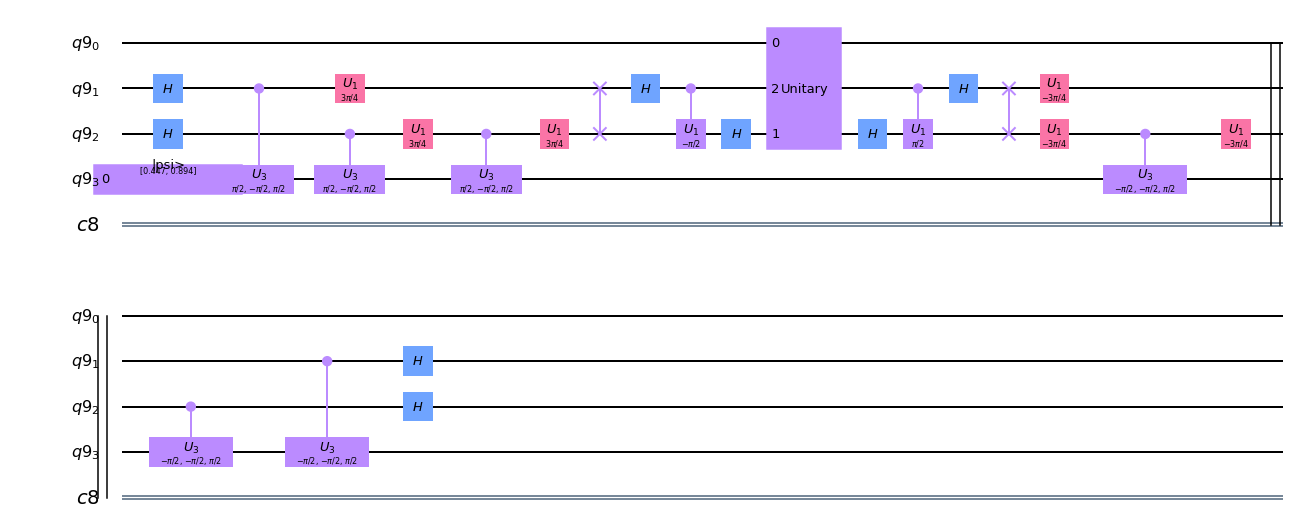

In [ ]:
qc.draw(output = 'mpl')

Looks really good. Now, we shall keep applying this circuit till result of measurement of the last qubit results in $0$. 

In [ ]:
while 1 == 1:  
  a = 2.3561945
  b = 0.78539817

  # Prepare the quantum circuit
  qr = QuantumRegister(5)
  cr = ClassicalRegister(1)
  qc = QuantumCircuit(qr, cr)

  y = np.array([1,2])
  y = y/np.linalg.norm(y)

  # Initialize b in qubit 3
  qc.ry(2 * np.arctan(y[1]/y[0]), 3)

  for i in range(2):
    qc.h(i + 1)

  # Apply controlled exponentiated matrix
  for control_qubit in range(2):
    for times in range(2 ** control_qubit):
      qc.cu3(2 * b, -np.pi/2, np.pi/2, control_qubit + 1, 3)
      qc.u1(a, control_qubit + 1)

  # Apply inverse QFT
  qc.swap(1,2)

  qc.h(1)

  qc.cu1(-np.pi/2, 1, 2)
  qc.h(2)

  # Apply U gate
  C = 1.5
  eig = np.pi/2
  qc.cu3(2 * np.arccos(C/eig), 0, 0, 2, 0)

  eig = np.pi
  qc.cu3(2 * np.arccos(C/eig), 0, 0, 1, 0)

  qc.ccx(1, 2, 4)

  eig = np.pi
  qc.cu3(-2 * np.arccos(C/eig), 0, 0, 4, 0)

  eig = np.pi/2
  qc.cu3(-2 * np.arccos(C/eig), 0, 0, 4, 0)

  eig = 3 * np.pi/2
  qc.cu3(2 * np.arccos(C/eig), 0, 0, 4, 0)

  # Apply QFT
  qc.h(2)
  qc.cu1(np.pi/2, 1, 2)

  qc.h(1)

  qc.swap(1,2)
  
  # Apply inverse controlled exponentiated matrix
  for control_qubit in range(1, -1, -1):
    for times in range(2 ** control_qubit):
      qc.u1(-a, control_qubit + 1)
      qc.cu3(-2 * b, -np.pi/2, np.pi/2, control_qubit + 1, 3)


  for i in range(2):
    qc.h(i + 1)

  qc.measure(0,0)

  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  temp = execute(qc, backend = sv_sim, shots = 1).result()
  statevector = temp.get_statevector()

  for key in temp.get_counts():
    flag = key

  if flag == '0':
    break


The actual answer we are looking for is

In [ ]:

act_mat = (a * np.eye(2)) + (b * X_gate)
ans = np.linalg.inv(act_mat) @ y
ans = ans/np.linalg.norm(ans)
print(ans)

[[0.19611613 0.98058068]]


The solution is stored in the fourth qubit of the final output. Let's retrieve that.

In [ ]:
[statevector[i] for i in range(16) if i % 8 == 0]

[(0.19611613513818435+5.365347491627783e-18j),
 (0.9805806756909201-3.727022609122049e-16j)]

This is exactly the required solution.